## Random Forest Classifier
The model predicts the severity of the landslide (or if there will even be one) within the next 2 days, based on weather data from the past 5 days.
A Random Forest model with 113 trees yielded an accuracy of 81.21% when trained on slope data and precipitation and wind data over a 5 day period.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.utils import shuffle
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [3]:
df = pd.read_csv("dataset.csv")
len(df)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


17808

In [4]:
df['severity'].value_counts()

medium          5594
small           2612
unknown          834
large            679
...              359
very_large       102
Medium            72
Unknown           19
Large             17
Small             10
catastrophic       4
landslide          2
Very_large         1
Very...large       1
Name: severity, dtype: int64

In [5]:
df['severity'].value_counts()
df = shuffle(df)
df.reset_index(inplace=True, drop=True)
print(len(df))

17808


In [6]:
X = df.copy()
y = X.landslide
columns=[]
for i in range(9, 4, -1):
    columns.append('humidity' + str(i))
    columns.append('ARI' + str(i))
columns.append('slope')
columns.append('forest2')
columns.append('realosm')
columns.append('lithology')
X = X[columns]

In [7]:
lith = dict()
numToLith = dict()
cnt = 0
for lithology in X['lithology']:
    if lithology not in lith:
        lith[lithology] = cnt
        numToLith[cnt] = lithology
        cnt += 1
        print("Added lithology: ", lithology)
lithCol = []
for lithology in X['lithology']:
    lithCol.append(lith[lithology])
X['lithology'] = lithCol
X

Added lithology:  mt
Added lithology:  sm
Added lithology:  sc
Added lithology:  ss
Added lithology:  su
Added lithology:  pa
Added lithology:  wb
Added lithology:  va
Added lithology:  vi
Added lithology:  pb
Added lithology:  ev
Added lithology:  ig
Added lithology:  vb
Added lithology:  nd
Added lithology:  py


,humidity9,ARI9,humidity8,ARI8,humidity7,ARI7,humidity6,ARI6,humidity5,ARI5,slope,forest2,realosm,lithology
0,99,17.802454,98,7.570666,98,7.744504,98,7.040050,98,5.883734,21.298,1,3,0
1,96,0.171259,96,0.238463,95,0.085033,89,0.033711,82,0.078465,0.000,0,0,0
2,100,2.296254,100,1.229348,100,0.612661,100,0.299753,100,0.186032,14.711,1,0,1
3,56,0.078288,70,0.704568,68,0.852414,70,0.252307,83,4.085462,21.209,1,4,1
4,83,0.590504,84,2.031458,89,3.396398,89,5.797771,91,1.738216,0.000,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17803,91,2.910657,89,1.157829,84,2.744639,94,3.452359,94,1.253482,6.679,0,2,4
17804,89,0.881687,97,1.352886,95,0.446675,89,0.629952,91,0.825351,4.208,1,97,8
17805,92,0.029178,93,0.015159,92,0.075626,92,0.021020,91,0.010537,5.002,1,0,2
17806,99,4.799773,99,7.833622,98,4.393393,97,2.902987,99,5.173442,34.083,1,41,0


## Scaling

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = X.to_numpy().tolist()

In [9]:
models = []
folds = []
foldsy = []
def createFolds(numFolds):
    global models
    global folds
    global foldsy
    models = []
    folds = []
    foldsy = []
    for p in range(0, len(X), int(len(X)/numFolds)):
        folds.append(X[p : p + int(len(X)/numFolds)])
        foldsy.append(y[p : p + int(len(y)/numFolds)])
    folds = folds[:numFolds]

In [10]:
def getValidation(numFolds, k):
    vscore = 0
    for kfold in range(numFolds):
        X_train = []
        y_train = []
        for index in range(numFolds):
            if index == kfold: continue
            X_train.extend(folds[index])
            y_train.extend(foldsy[index])
        X_test = folds[kfold]
        y_test = foldsy[kfold]
        model = RandomForestClassifier(n_estimators = k)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        vscore += accuracy_score(pred, y_test)
    return vscore/numFolds

In [11]:
def getBest(numFolds, loK, maxK, verbose = False):
    bestK = loK
    bestV = 0
    createFolds(numFolds)
    for k in range(loK, maxK + 1):
        res = getValidation(numFolds, k)
        if(res > bestV):
            bestV = res
            bestK = k
            if verbose:
                print(k, "is better:", res)
    return bestK, bestV

In [12]:
n, val = getBest(10, 20, 140, True)
print("Use: ", n, "=", val)

20 is better: 0.8970224719101123
21 is better: 0.8981460674157304
23 is better: 0.8988202247191012
27 is better: 0.8992134831460674
29 is better: 0.8998876404494383
32 is better: 0.9001685393258427
42 is better: 0.9013483146067415
55 is better: 0.9015168539325842
59 is better: 0.9015730337078651
64 is better: 0.9024157303370786
72 is better: 0.9024157303370787
138 is better: 0.9028089887640448
Use:  138 = 0.9028089887640448


## Prediction

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = RandomForestClassifier(n_estimators = n, oob_score = True)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=138, oob_score=True)

In [14]:
pred = model.predict(X_test)
print("ACCURACY:", accuracy_score(pred, y_test))

ACCURACY: 0.8944413250982594


In [15]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_test, pred)
array

array([[1241,  233],
       [ 143, 1945]])

In [16]:
# array = [[1254,245],[161,1902]]

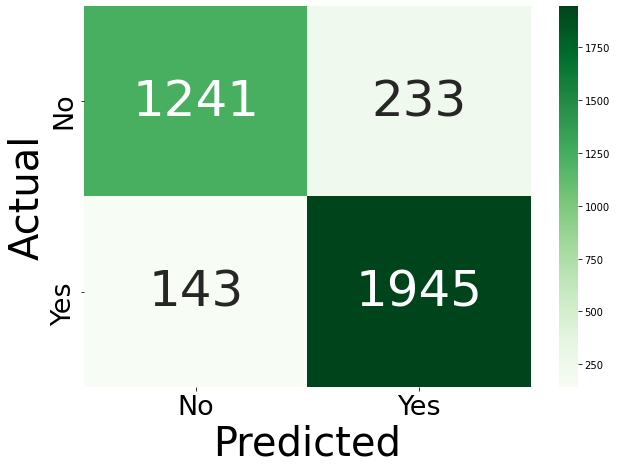

In [17]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
binary=True
if binary:
    df_cm = pd.DataFrame(array, index = [i for i in ["No", "Yes"]],
                    columns = [i for i in ["No", "Yes"]])
else:
    df_cm = pd.DataFrame(array, index = [i for i in ["None", "Small", "Medium", "Large", "Very Large"]],
                  columns = [i for i in ["None", "Small", "Medium", "Large", "Very Large"]])

plt.figure(figsize = (10,7))

ax = sn.heatmap(df_cm, cmap="Greens", annot=True, annot_kws={"size":50}, fmt='g')
ax.tick_params(axis='both', which='major', labelsize=27)
plt.xlabel('Predicted', fontsize = 40) 
# plt.title("KNN Confusion Matrix", fontsize = 50)
plt.ylabel('Actual', fontsize = 40) 
plt.savefig("Lith Valid RF Matrix", bbox_inches="tight")

plt.show()

In [18]:
print(model.oob_score_)

0.9004632879404745
